In [7]:
!python -c "import numpy; print(numpy.__version__)"
!python -c "import scipy; print(scipy.__version__)"

2.3.5
1.16.3


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

ImportError: cannot import name '_lazywhere' from 'scipy._lib._util' (C:\Users\lenovo\anaconda3\Lib\site-packages\scipy\_lib\_util.py)

In [16]:
df = pd.read_csv('C:/Users/lenovo/Desktop/data.csv')
print(df.head())
print(df.info())

      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7388318 entries, 0 to 7388317
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 338.2 MB
None


In [24]:
df.columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

df['datetime'] = pd.to_datetime(df['Timestamp'], unit='s')

df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

print("\n数据类型:")
print(df.dtypes)

print("\n缺失值统计:")
print(df.isnull().sum())

df.dropna(subset=['Open', 'Close'], inplace=True)  # 关键价格不能为空

duplicates = df.index.duplicated(keep=False)
if duplicates.any():
    print(f"发现 {duplicates.sum()} 个重复时间点")
    df = df[~duplicates]


数据类型:
Timestamp    float64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object

缺失值统计:
Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


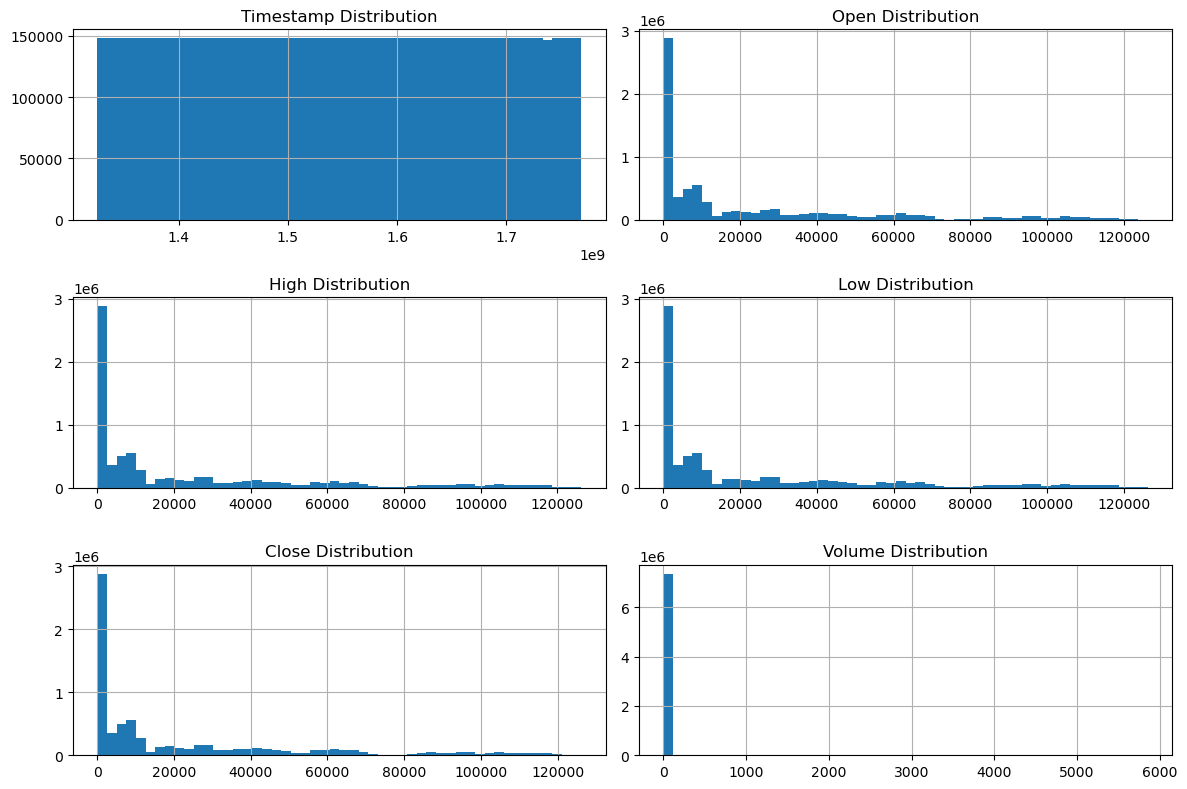

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for idx, col in enumerate(df.columns):
    ax = axes[idx//2, idx%2]
    df[col].hist(bins=50, ax=ax)
    ax.set_title(f'{col} Distribution')
plt.tight_layout()
plt.show()

In [34]:
# 方法1：基于对数收益率的异常检测（最适合价格数据）
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# 计算滚动波动率
window = 30  # 30天窗口
df['rolling_volatility'] = df['log_return'].rolling(window=window).std()

# 标记异常收益率（超过4个标准差）
df['return_zscore'] = df['log_return'] / df['rolling_volatility']
return_anomalies = df[abs(df['return_zscore']) > 4]
print(f"异常收益率事件数量: {len(return_anomalies)}")

# 方法2：检测价格数据错误（非市场波动）
# 检查明显的数据错误
data_errors = pd.DataFrame()

# 1. High < Low 的逻辑错误
data_errors['high_lt_low'] = df['High'] < df['Low']

# 2. 价格跳跃过大（日变化超过50%）
df['daily_change_pct'] = df['Close'].pct_change() * 100
data_errors['extreme_jump'] = abs(df['daily_change_pct']) > 50

# 3. 价格超出合理范围（比特币历史范围）
data_errors['price_out_of_range'] = (df['Close'] < 10) | (df['Close'] > 200000)

# 4. 价格不一致（Close不在[Low, High]区间内）
data_errors['close_out_of_range'] = (df['Close'] < df['Low']) | (df['Close'] > df['High'])

print("数据错误统计:")
print(data_errors.sum())

异常收益率事件数量: 30379
数据错误统计:
high_lt_low                0
extreme_jump               4
price_out_of_range    316030
close_out_of_range         0
dtype: int64


In [35]:
# 修复明显的数据错误
df_clean = df.copy()

# 1. 修正 High < Low 的错误
mask = df_clean['High'] < df_clean['Low']
df_clean.loc[mask, ['High', 'Low']] = df_clean.loc[mask, ['Low', 'High']].values

# 2. 删除价格超出历史范围的数据（如<1或>200,000）
# 但这里要小心，比特币曾经很低，可能<1是早期价格
btc_historical_min = 0.01  # 比特币历史最低约$0.003
btc_historical_max = 200000  # 设置合理上限

df_clean = df_clean[(df_clean['Close'] >= btc_historical_min) & 
                    (df_clean['Close'] <= btc_historical_max)]

# 3. 检查成交量异常
# 比特币成交量变化很大，但为0可能有问题
zero_volume = df_clean[df_clean['Volume'] == 0]
print(f"成交量为0的记录: {len(zero_volume)}")

# 可以填充或删除（如果数量不多）
if len(zero_volume) / len(df_clean) < 0.01:  # 小于1%
    df_clean = df_clean[df_clean['Volume'] > 0]

成交量为0的记录: 1310606


AttributeError: 'numpy.ndarray' object has no attribute 'plt'

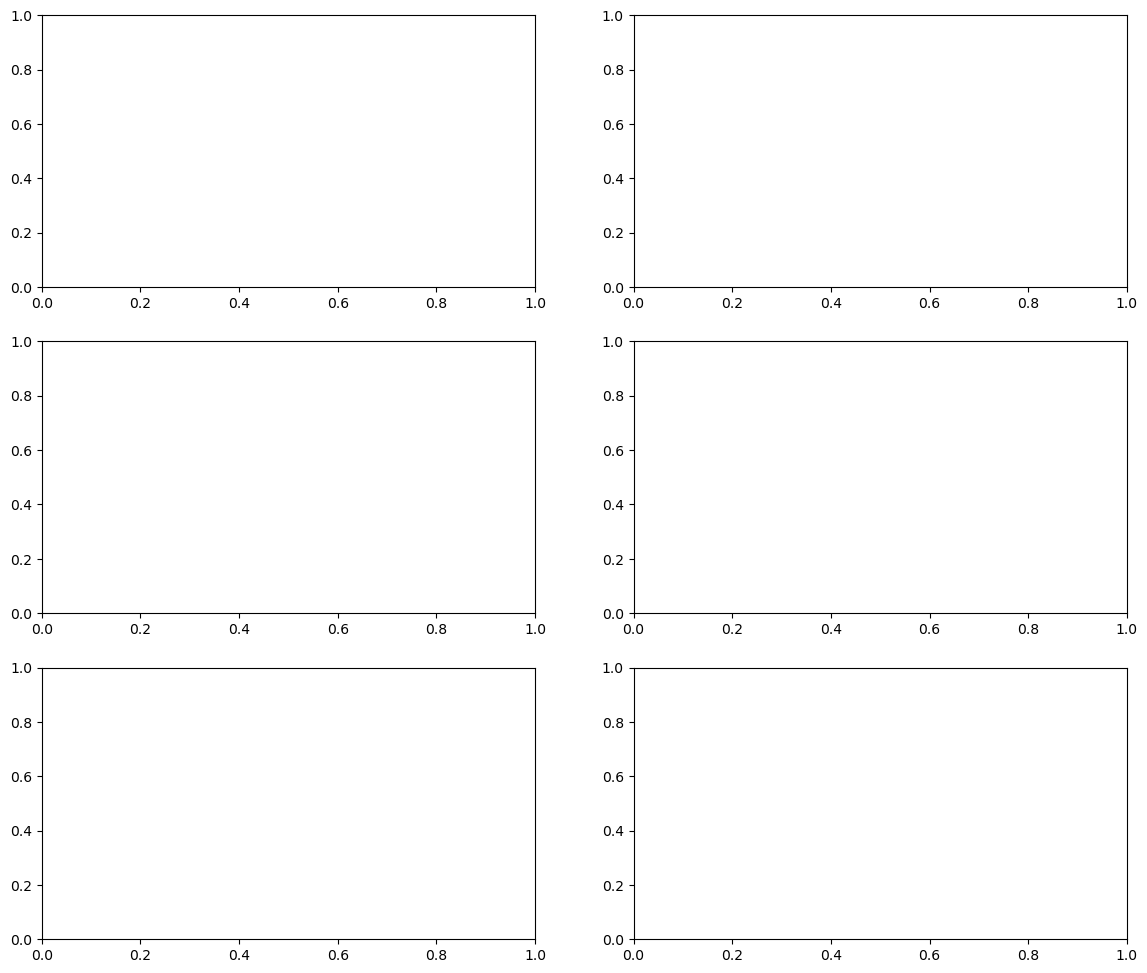

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1. 价格时间序列
axes[0].plot(df_clean['datetime'], df_clean['Close'], linewidth=0.5)
axes[0].set_title('Bitcoin Price History')
axes[0].set_ylabel('Price')
axes[0].grid(True, alpha=0.3)

# 2. 对数收益率分布
axes[1].hist(df_clean['log_return'].dropna(), bins=100, alpha=0.7)
axes[1].axvline(df_clean['log_return'].mean(), color='red', linestyle='--', label='Mean')
axes[1].set_title('Log Returns Distribution')
axes[1].set_xlabel('Log Return')
axes[1].legend()

# 3. 滚动波动率
axes[2].plt(df_clean['datetime'], df_clean['rolling_volatility'])
axes[2].set_title('30-Day Rolling Volatility')
axes[2].set_ylabel('Volatility')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()